In [1]:
# SETUP CELL - Run this ONCE to install Playwright browsers
# After running once, you can comment out or skip this cell

import subprocess
import sys

# Install Playwright browsers (chromium is usually sufficient)
result = subprocess.run(
    [sys.executable, "-m", "playwright", "install", "chromium"],
    capture_output=True,
    text=True
)
print("STDOUT:", result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr)
else:
    print("[OK] Playwright chromium browser installed")


STDOUT: 
[OK] Playwright chromium browser installed


In [2]:
# Playwright in Jupyter on Windows requires running in a SEPARATE PROCESS
# This wrapper handles subprocess communication

import subprocess
import json
import sys
from pathlib import Path

class PlaywrightWrapper:
    """Wrapper that runs Playwright commands in a separate process."""
    
    def __init__(self):
        self.helper_script = Path(__file__).parent / "playwright_helper.py" if '__file__' in dir() else Path("playwright_helper.py")
        self.python_exe = sys.executable
        
    def _run_command(self, command: str, args: dict = None) -> dict:
        """Run a Playwright command via subprocess."""
        args = args or {}
        cmd = [self.python_exe, str(self.helper_script), command, json.dumps(args)]
        
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=60)
        
        if result.returncode != 0:
            return {"success": False, "error": result.stderr}
        
        try:
            return json.loads(result.stdout)
        except json.JSONDecodeError:
            return {"success": False, "error": f"Invalid JSON: {result.stdout}"}
    
    def test(self) -> dict:
        """Test Playwright connectivity."""
        return self._run_command("test")
    
    def navigate(self, url: str) -> dict:
        """Navigate to a URL and get page info."""
        return self._run_command("navigate", {"url": url})
    
    def get_page_content(self, url: str) -> dict:
        """Get page content from a URL."""
        return self._run_command("get_page_content", {"url": url})
    
    def screenshot(self, url: str, path: str = "screenshot.png") -> dict:
        """Take a screenshot of a page."""
        return self._run_command("screenshot", {"url": url, "path": path})
    
    def get_tools(self) -> list:
        """Get list of available tools."""
        result = self._run_command("get_tools")
        return result.get("data", []) if result.get("success") else []

# Create the wrapper
pw = PlaywrightWrapper()

# Test it
test_result = pw.test()
if test_result.get("success"):
    print(f"[OK] Playwright working! Page title: {test_result['data']['title']}")
else:
    print(f"[ERROR] {test_result.get('error')}")

# Show available tools
tools = pw.get_tools()
print(f"[OK] Available tools: {tools}")

[OK] Playwright working! Page title: Fast and reliable end-to-end testing for modern web apps | Playwright
[OK] Available tools: ['click_element', 'navigate_browser', 'previous_webpage', 'extract_text', 'extract_hyperlinks', 'get_elements', 'current_webpage']


In [3]:
# Test navigation using the wrapper
result = pw.navigate("https://www.google.com")
if result.get("success"):
    print(f"[OK] Navigated to: {result['data']['url']}")
    print(f"    Title: {result['data']['title']}")
else:
    print(f"[ERROR] {result.get('error')}")

# Get page content
content_result = pw.get_page_content("https://playwright.dev")
if content_result.get("success"):
    print(f"\n[OK] Got content from: {content_result['data']['url']}")
    print(f"    Title: {content_result['data']['title']}")
    print(f"    Content preview: {content_result['data']['content'][:200]}...")

[OK] Navigated to: https://www.google.com/
    Title: Google

[OK] Got content from: https://playwright.dev/
    Title: Fast and reliable end-to-end testing for modern web apps | Playwright
    Content preview: <!DOCTYPE html><html lang="en" dir="ltr" class="plugin-pages plugin-id-default" data-has-hydrated="false" data-theme="light" data-theme-choice="system" data-rh="lang,dir,class"><head><meta charset="UT...


[OK] Screenshot saved to: playwright_screenshot.png
    Page title: Fast and reliable end-to-end testing for modern web apps | Playwright


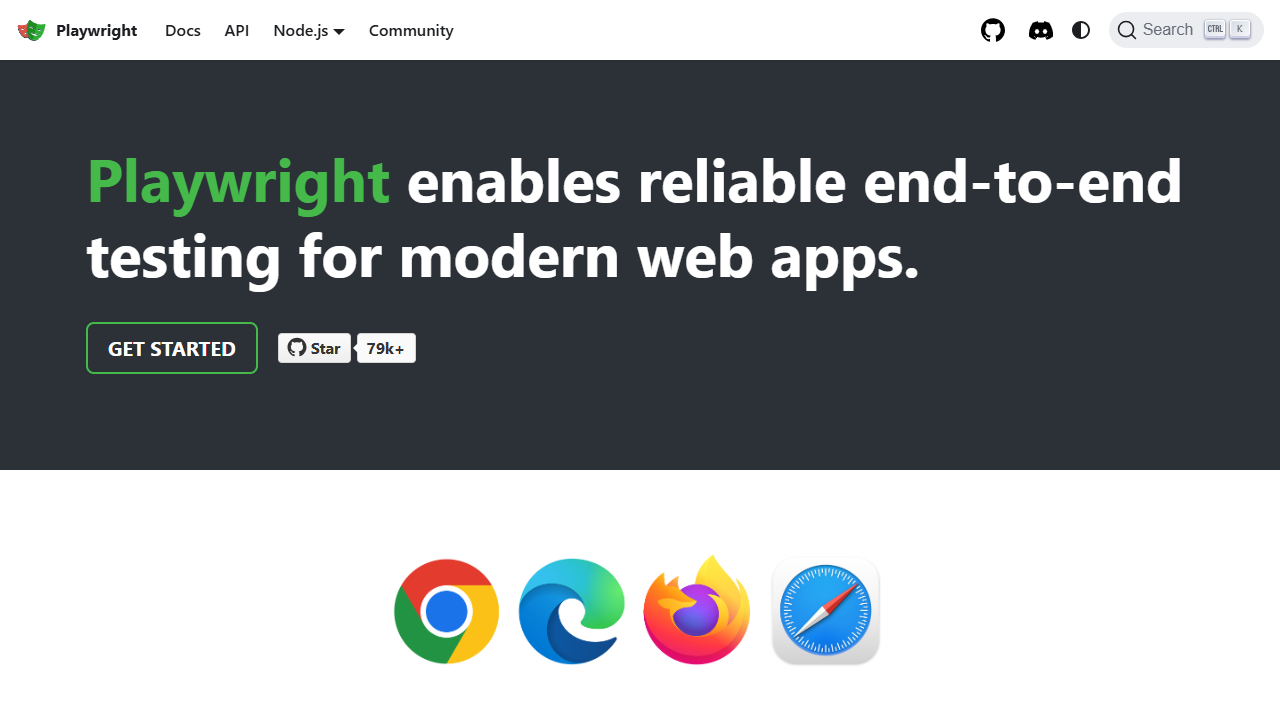

In [8]:
# Take a screenshot example
screenshot_result = pw.screenshot("https://playwright.dev", "playwright_screenshot.png")
if screenshot_result.get("success"):
    print(f"[OK] Screenshot saved to: {screenshot_result['data']['path']}")
    print(f"    Page title: {screenshot_result['data']['title']}")
    
    # Display the screenshot in Jupyter
    from IPython.display import Image, display
    display(Image(filename="playwright_screenshot.png"))
else:
    print(f"[ERROR] {screenshot_result.get('error')}")


In [11]:
# Demo: Multi-step navigation with clicking (using subprocess wrapper)
# This replicates the async example but works in Jupyter on Windows

# Method 1: Use the scrape_quotes command (pre-built demo)
scrape_result = pw._run_command("scrape_quotes", {})
if scrape_result.get("success"):
    data = scrape_result["data"]
    print(f"Title: {data['title']}")
    print(f"\nPage 1: {data['pages'][0]['url']}")
    print(f"  Quotes preview: {data['pages'][0]['quotes_preview'][0][:50]}...")
    print(f"\nPage 2 (after clicking Next): {data['pages'][1]['url']}")
    print(f"  Quotes preview: {data['pages'][1]['quotes_preview'][0][:50]}...")
else:
    print(f"[ERROR] {scrape_result.get('error')}")

# Method 2: Use navigate_and_click for custom interactions
print("\n--- Custom Navigate + Click ---")
click_result = pw._run_command("navigate_and_click", {
    "url": "https://quotes.toscrape.com/",
    "selector": "li.next a",  # Use space instead of > for PowerShell compatibility
    "wait_until": "networkidle"
})
if click_result.get("success"):
    data = click_result["data"]
    print(f"Initial URL: {data['initial_url']}")
    print(f"After clicking 'Next': {data['final_url']}")
else:
    print(f"[ERROR] {click_result.get('error')}")

Title: Quotes to Scrape

Page 1: https://quotes.toscrape.com/
  Quotes preview: “The world as we have created it is a process of o...

Page 2 (after clicking Next): https://quotes.toscrape.com/page/2/
  Quotes preview: “This life is what you make it. No matter what, yo...

--- Custom Navigate + Click ---
Initial URL: https://quotes.toscrape.com/
After clicking 'Next': https://quotes.toscrape.com/page/2/


In [14]:
# Demo: Login to saucedemo.com and get product list (using subprocess wrapper)
# This replicates the async login example but works in Jupyter on Windows

login_result = pw._run_command("login_demo", {
    "url": "https://www.saucedemo.com/",
    "username": "standard_user",
    "password": "secret_sauce"
})

if login_result.get("success"):
    data = login_result["data"]
    print(f"[OK] Logged in successfully!")
    print(f"    URL after login: {data['url']}")
    print(f"\nFound {len(data['products'])} products:")
    for name in data['products']:
        print(f"  - {name}")
else:
    print(f"[ERROR] {login_result.get('error')}")

[OK] Logged in successfully!
    URL after login: https://www.saucedemo.com/inventory.html

Found 6 products:
  - Sauce Labs Backpack
  - Sauce Labs Bike Light
  - Sauce Labs Bolt T-Shirt
  - Sauce Labs Fleece Jacket
  - Sauce Labs Onesie
  - Test.allTheThings() T-Shirt (Red)
